In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import dill as pickle

import quail
import requests
import os
import warnings

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

# Download/organize the data

In [2]:
# set up labels and directories

datadir = os.path.join(os.path.split(os.getcwd())[0], 'data', 'eggs')
if not os.path.exists(datadir):
    os.makedirs(datadir)

urls = {
    'exp1': 'https://www.dropbox.com/s/wbihewq631onsj8/exp1.egg?dl=1',
    'exp2': 'https://www.dropbox.com/s/kliq92lta7mvqcc/exp2.egg?dl=1',
    'exp3': 'https://www.dropbox.com/s/3se8ee2fahf9hvc/exp3.egg?dl=1',
    'exp4': 'https://www.dropbox.com/s/9xd2v4fofk1uqv2/exp4.egg?dl=1',
    'exp5': 'https://www.dropbox.com/s/lox770xxs2d7ypm/exp5.egg?dl=1',
    'exp6': 'https://www.dropbox.com/s/afp5ml563b46s6q/exp6.egg?dl=1',
    'exp7': 'https://www.dropbox.com/s/43nq4egicrxc31p/exp7.egg?dl=1',
    'exp8': 'https://www.dropbox.com/s/j7j2bldr24wybwu/exp8.egg?dl=1',
    'exp10': 'https://www.dropbox.com/s/gp3av93kvlzsgpw/exp10.egg?dl=1',
    'exp11': 'https://www.dropbox.com/s/5227s2pg5o8krda/exp11.egg?dl=1',
    'exp12': 'https://www.dropbox.com/s/leqll4o8ih587fa/exp12.egg?dl=1'
    }

descriptions = {
    'exp1': 'feature rich',
    'exp2': 'category',
    'exp3': 'color',
    'exp4': 'length',
    'exp5': 'first letter',
    'exp6': 'location',
    'exp10': 'size',
    'exp7': 'reduced (early)',
    'exp8': 'reduced (late)',                
    'exp12': 'reduced',
    'exp11': 'adaptive'
    }

feature_groupings = {
    'random': ['feature rich', 'reduced (early)', 'reduced (late)', 'reduced'],
    'semantic': ['category', 'size'],
    'lexicographic': ['length', 'first letter'],
    'visual': ['color', 'location'],
    'adaptive': ['random', 'stabilize', 'destabilize']
    }

colors = {
    'feature rich': '#c0673c',
    'reduced (early)': '#f15a22',
    'reduced (late)': '#f7996c',
    'reduced': '#fddac5',
    'category': '#524fa1',
    'size': '#aca7d3',
    'length': '#cbdb2a',
    'first letter': '#e8eeae',
    'color': '#00a651',
    'location': '#9bd3ae',
    'random': '#407b8d',
    'stabilize': '#00addc',
    'destabilize': '#90d7ee',
    'init': '#d3d3d3'
}

def grouping(feature):
    try:
        return [k for k, v in feature_groupings.items() if feature in v][0]
    except:
        return None

In [3]:
# (down)load the data from each experimental condition
def load_egg(fname, url=None):    
    fname = os.path.join(datadir, fname)
    if os.path.exists(fname):
        print('.', end='')
        return quail.load_egg(fname)

    print('o', end='')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    
    return load_egg(fname)

def fetch_data():
    print('loading data', end='')
    data = {descriptions[x]: load_egg(f'{x}.egg', u) for x, u in urls.items()}
    print('done!')

    return data

# Do some basic analyses

Compute for each experiment:
- Probability of first recall (pfr): plot probability of recalling each item *first* as a function of the presentation position
    - Advanced: also do probability of $n^{th}$ recall for $n \in \{0, ..., 15\}$
- Lag conditional response probability (lagcrp): plot the probability of recalling each item next in the sequence, as a function of their positions relative to the position of the item recalled just previously
- Serial position curve (spc): plot the probability of recalling each item (at *any* point) as a function of the presentation position
- Fingerprint: compute clustering scores across different features

For each analysis:
- Look at "early" vs. "late" lists

### To do:
- Use word2vec or GLoVE to compute word embeddings (tag as "semantic" features)

In [4]:
def apply(egg, analysis, listgroup=None):
    warnings.simplefilter('ignore')

    if listgroup is None:
        if 'listgroup' not in egg.meta:
            listgroup = ['Early' if i < 8 else 'Late' for i in range(16)]
        else:
            listgroup = egg.meta['listgroup']

    if type(analysis) is str:
        kwargs = {}
    else:
        analysis, kwargs = analysis
    
    return egg.analyze(analysis, listgroup=listgroup, **kwargs)


def get_listgroups(data):
    listgroups = {}
    for k, egg in data.items():
        if 'listgroup' not in egg.meta:
            listgroups[k] = ['Early' if i < 8 else 'Late' for i in range(16)]
        else:
            listgroups[k] = egg.meta['listgroup']
    return listgroups
    

def analyze_data(data, analyses):
    results = {}

    print('basic analyses...')
    for a in tqdm(analyses):
        results[a] = {x: apply(d, a) for x, d in data.items()}
    
    print('pnr analyses...')
    pnr_results = {}
    for i in tqdm(range(16)):
        pnr_results[i] = {x: apply(d, ['pnr', {'position': i}]) for x, d in data.items()}

    results['pnr'] = pnr_results

    print('accuracy by list...')
    listgroup = list(range(16))
    results['accuracy by list'] = {k: apply(egg, 'accuracy', listgroup) for k, egg in data.items()}

    return results

In [5]:
results_file = os.path.join(datadir, 'analyzed.pkl')

if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        results, analyses, listgroups = pickle.load(f)
else:
    data = fetch_data()
    analyses = ['lagcrp', 'spc', 'accuracy', 'fingerprint']
    results = analyze_data(data, analyses)
    listgroups = get_listgroups(data)
    
    with open(results_file, 'wb') as f:
        pickle.dump([results, analyses, listgroups], f)

Set up figure directory...

In [6]:
figdir = os.path.join(os.path.split(os.getcwd())[0], 'paper', 'figures', 'source')
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Figure 1: recall dynamics across different experimental conditions

We'll use three basic analyses to characterize recall dynamics:
  - What word do participants recall *first*?  (Probability of first recall)
  - How to participants *transition* from recalling one word to recalling other words (from the same list)?  (Lag Conditional Response Probability)
  - Which words do participants recall *overall*? (Serial position curve)

In [7]:
non_adaptive = [x for x in descriptions.values() if x != 'adaptive']

def select_conds(results, conds='all'):
    return {k: v for k, v in results.items() if conds == 'all' or k in conds}

def select_lists(fried, lists='all'):
    if type(fried) is dict:
        return {k: select_lists(v, lists=lists) for k, v in fried.items()}

    x_data = fried.data.copy()
    if lists == 'all':
        x_data.index = pd.MultiIndex.from_tuples([(i, 'Average') for i, _ in x.data.index], names=x.data.index.names)        
    elif type(lists) is str:
        x_data = x_data.query(f'List == "{lists}"')
    else:
        x_data = x_data.query(f'List in @lists')

    return quail.FriedEgg(data=x_data.copy(), analysis=fried.analysis, list_length=fried.list_length,
                          n_lists=fried.n_lists, n_subjects=fried.n_subjects, position=fried.position)


def filter(x, include_conds='all', include_lists='all'):
    x = {k: select_lists(v, lists=include_lists) for k, v in select_conds(x, conds=include_conds).items()}
    include_conds = list(x.keys())
    include_conds.sort()

    include_keys = []
    for k, v in x.items():
        include_keys.extend(np.unique([i for _, i in v.data.index]).tolist())
    include_keys = np.unique(include_keys).tolist()

    return x, include_conds, include_keys


def combo_plot(x, include_conds='all', include_lists='all', fname=None, xlabel=None, ylabel=None, xlim=None, ylim=None, palette=None):
    x, include_conds, include_lists = filter(x, include_conds, include_lists)

    fig = plt.figure(figsize=(3, 2.5))
    ax = plt.gca()
    
    for c in include_conds:
        if palette is None:
            if c.lower() in colors:
                next_palette = [colors[c.lower()]]
            else:
                next_palette = [colors[i.lower()] for i in include_lists]
        else:
            next_palette = palette
    
        x[c].plot(ax=ax, palette=next_palette, legend=False)
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)

    if xlim is not None:
        plt.xlim(xlim)
    
    if ylim is not None:
        plt.ylim(ylim)
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

Probability of first recall (early + late)

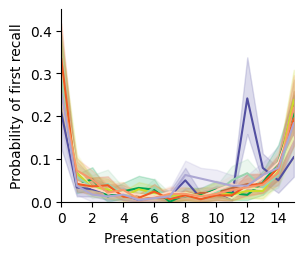

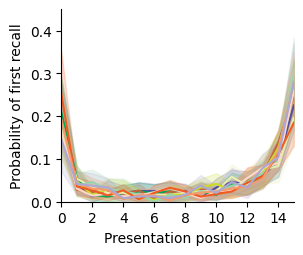

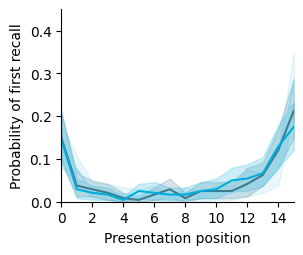

In [8]:
combo_plot(results['pnr'][0], include_conds=non_adaptive, include_lists='Early', fname='pfr_early_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);
combo_plot(results['pnr'][0], include_conds=non_adaptive, include_lists='Late', fname='pfr_late_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);
combo_plot(results['pnr'][0], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='pfr_adaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=[0, 0.45]);

Lag conditional response probability

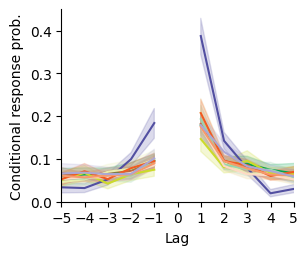

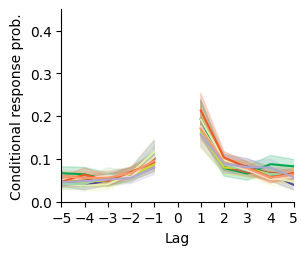

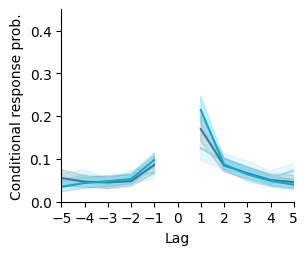

In [9]:
combo_plot(results['lagcrp'], include_conds=non_adaptive, include_lists='Early', fname='crp_early_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);
combo_plot(results['lagcrp'], include_conds=non_adaptive, include_lists='Late', fname='crp_late_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);
combo_plot(results['lagcrp'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='crp_adaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=[0, 0.45]);

Serial position curves

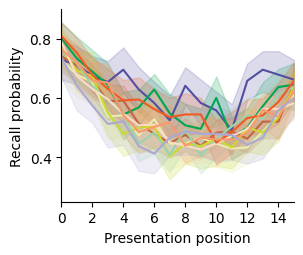

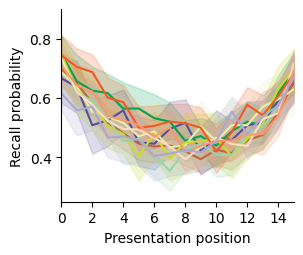

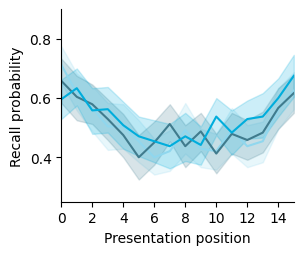

In [10]:
combo_plot(results['spc'], include_conds=non_adaptive, include_lists='Early', fname='spc_early_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);
combo_plot(results['spc'], include_conds=non_adaptive, include_lists='Late', fname='spc_late_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);
combo_plot(results['spc'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='spc_adaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=[0.25, 0.9]);

# Figure 2: early versus late differences in recall dynamics

For the non-adaptive conditions, recall dynamics on early vs. late lists reflect performance under difference conditions:
  - Feature rich, reduced: control conditions
    - Feature rich: random word order on both early and late lists; visual features vary across words
    - Reduced: random word order on both early and late lists; visual features held constant across words
  - Category, size, length, first letter, color, location
    - Words are sorted by the given feature during the first 8 lists ("Early")
    - Words order is randomized for the second 8 lists ("Late")
  - Reduced (early), Reduced (late):
    - Word order is randomized in all lists, for both conditions
    - Reduced (early): visual features are held constant for the first 8 lists ("Early") but vary for the second 8 lists ("Late")
    - Reduced (late): visual features vary for the first 8 lists but are held constant for the second 8 lists
  
Each adaptive conditions reflects lists presented in a different (relative) order, according to the participant's average "fingerprint" from all lists up to that point:
  - Random: control condition; words are sorted randomly
  - Stabilize: words are sorted to *maximize* agreement with the participant's average fingerprint
  - Destabilize: words are sorted to *minimize* agreement with the participant's average fingerprint

In [11]:
def egg_diff(a, b):
    if type(a) is dict:
        results = {}
        for k in a.keys():
            results[k] = egg_diff(a[k], b[k])
        return results
    
    for i in ['analysis', 'list_length', 'n_lists', 'n_subjects', 'position']:
        assert getattr(a, i) == getattr(b, i), ValueError('Incompatable eggs; cannot take difference')
    assert np.all([i == j for i, j in zip(a.data.shape, b.data.shape)]), ValueError('Incompatable eggs; cannot take difference')
    
    #idx = pd.MultiIndex.from_tuples([(i, 'Difference') for i, _ in a.data.index], names=a.data.index.names)
    diffs = pd.DataFrame(index=a.data.index, data=a.data.values - b.data.values, columns=a.data.columns)  # Hack: name "differences" using the reference item's name so that coloring works correctly

    return quail.FriedEgg(data=diffs, analysis=a.analysis, list_length=a.list_length,
                          n_lists=a.n_lists, n_subjects=a.n_subjects, position=a.position)
    
def get_diffs(x, contrast={'Late': 'Early'}, include_conds='all' ):
    include_lists = []
    for k, v in contrast.items():
        include_lists.extend([k, v])
    include_lists = np.unique(include_lists).tolist()
        
    x, include_conds, include_lists = filter(x, include_conds, include_lists)
    
    diffs = {}
    for k, v in contrast.items():
        diffs[f'{k} - {v}'] = egg_diff(select_lists(x, k), select_lists(x, v))

    return diffs

def stack_diffs(diffs, include_conds='all'):
    if include_conds == 'all':
        include_conds = []
        for k1, v1 in diffs.items():
            for k2, _ in v1.items():
                include_conds.append(k2)
        include_conds = np.unique(include_conds).tolist()
    elif type(include_conds) is str:
        include_conds = [include_conds]    

    template = diffs
    while type(template) is not quail.FriedEgg:
        template = template[list(template.keys())[0]]
    
    analysis = template.analysis
    list_length = template.list_length
    n_lists = template.n_lists
    n_subjects = template.n_subjects
    position = template.position

    results = {}
    for c in include_conds:
        results[c] = quail.FriedEgg(pd.concat([x[c].data for x in diffs.values()], axis=0),
            analysis=analysis, list_length=list_length, n_lists=n_lists,
            n_subjects=n_subjects, position=position)
    return results

Probability of first recall differences

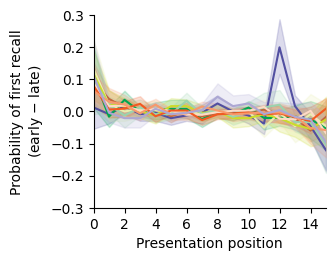

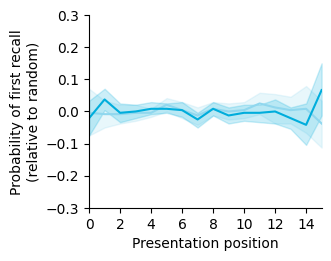

In [12]:
pfr_diffs = get_diffs(results['pnr'][0], contrast={'Early': 'Late'}, include_conds=non_adaptive)['Early - Late']
combo_plot(pfr_diffs, include_conds=non_adaptive, include_lists=['Early'], fname='pfr_nonadaptive_diffs', xlabel='Presentation position', ylabel='Probability of first recall\n(early $-$ late)', ylim=[-0.3, 0.3]);

pfr_diffs_adaptive = get_diffs(results['pnr'][0], contrast={'stabilize': 'random', 'destabilize': 'random'}, include_conds='adaptive')
combo_plot(stack_diffs(pfr_diffs_adaptive), include_lists=['stabilize', 'destabilize'], fname='pfr_adaptive_diffs', xlabel='Presentation position', ylabel='Probability of first recall\n(relative to random)', ylim=[-0.3, 0.3]);

Lag conditional response probability differences

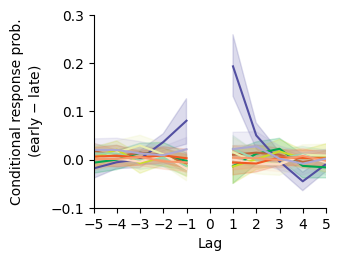

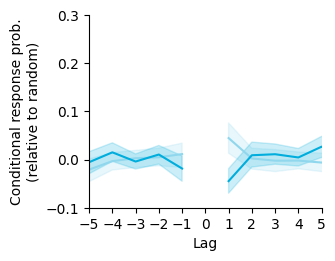

In [13]:
crp_diffs = get_diffs(results['lagcrp'], contrast={'Early': 'Late'}, include_conds=non_adaptive)['Early - Late']
combo_plot(crp_diffs, include_conds=non_adaptive, include_lists=['Early'], fname='crp_nonadaptive_diffs', xlabel='Lag', ylabel='Conditional response prob.\n(early $-$ late)', ylim=[-0.1, 0.3]);

crp_diffs_adaptive = get_diffs(results['lagcrp'], contrast={'stabilize': 'random', 'destabilize': 'random'}, include_conds='adaptive')
combo_plot(stack_diffs(crp_diffs_adaptive), include_lists=['stabilize', 'destabilize'], fname='crp_adaptive_diffs', xlabel='Lag', ylabel='Conditional response prob.\n(relative to random)', ylim=[-0.1, 0.3]);

Serial position curve differences

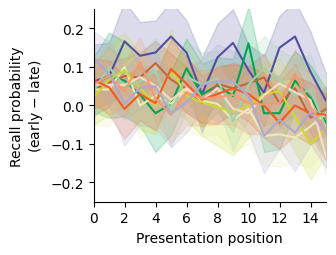

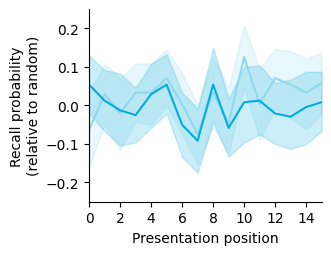

In [14]:
spc_diffs = get_diffs(results['spc'], contrast={'Early': 'Late'}, include_conds=non_adaptive)['Early - Late']
combo_plot(spc_diffs, include_conds=non_adaptive, include_lists=['Early'], fname='spc_nonadaptive_diffs', xlabel='Presentation position', ylabel='Recall probability\n(early $-$ late)', ylim=[-0.25, 0.25]);

spc_diffs_adaptive = get_diffs(results['spc'], contrast={'stabilize': 'random', 'destabilize': 'random'}, include_conds='adaptive')
combo_plot(stack_diffs(spc_diffs_adaptive), include_lists=['stabilize', 'destabilize'], fname='spc_adaptive_diffs', xlabel='Presentation position', ylabel='Recall probability\n(relative to random)', ylim=[-0.25, 0.25]);

 # Figure 3: detailed recall initiation dynamics

- For each non-adaptive condition, create early, late, and diff heatmaps: row = recall position; column = output position; color = p(recall)
- For each adaptive condition, create stabilize, destabilize, random, and diff (stabilize vs. random, destabilize vs. random) heatmaps in the same format

 

In [15]:
def pnr_matrix(pnr_results, include_conds='all', include_lists='all'):
    positions = range(16)

    if type(include_conds) is str:
        include_conds = [include_conds]
    
    if type(include_lists) is str:
        include_lists = [include_lists]

    conds = [c for c in pnr_results[positions[0]].keys() if 'all' in include_conds or c in include_conds]

    matrices = {}
    for c in conds:
        matrices[c] = {}
        
        x = pd.concat([pnr_results[p][c].data.groupby('List').mean() for p in positions], axis=0)
        lists = np.unique(x.index.values).tolist()

        for ls in lists:
            if 'all' in include_lists or ls in include_lists:
                matrices[c][ls] = x.query(f'List == "{ls}"').reset_index().drop('List', axis=1)

    return matrices

def mini_filter(x, include_conds='all', include_lists='all'):
    conds = []
    lists = []

    if type(include_conds) is str and include_conds != 'all':
        include_conds = [include_conds]

    if type(include_lists) is str and include_lists != 'all':
        include_lists = [include_lists]
    


    results = {}
    for k1 in x.keys():
        if not (include_conds == 'all' or k1 in include_conds):
            continue
        
        results[k1] = {}
        conds.append(k1)
        
        for k2, v in x[k1].items():
            if not (include_lists == 'all' or k2 in include_lists):
                continue

            results[k1][k2] = x[k1][k2]
            lists.append(k2)
    
    return results, np.unique(conds).tolist(), np.unique(lists).tolist()

In [16]:
def sort_by_grouping(vals, groupings):
    sorted_vals = []
    for category, exemplars in groupings.items():
        sorted_vals.extend([x for x in exemplars if x in vals])
    
    missing = [v for v in vals if v not in sorted_vals]
    sorted_vals.extend(missing)
    
    return sorted_vals

In [17]:
def plot_pnr_heatmaps(results, include_conds='all', include_lists='all', contrasts=None, fname=None, vmin=0, vmax=1.0, dvmin=-1.0, dvmax=1.0, fontsize=12, width=2.5, height=2):
    def heatmap(m, title, vmn, vmx, ax, showx=False, showy=False, show_title=False, yprepend='', **kwargs):
        sns.heatmap(m, vmin=vmn, vmax=vmx, ax=ax, cbar=False, **kwargs)

        if showx:
            ax.set_xlabel('Presentation position', fontsize=fontsize)
        if showy:
            ax.set_ylabel(yprepend + 'Output position', fontsize=fontsize)
        if show_title:
            ax.set_title(title, fontsize=fontsize)
        return plt.gca()
    
    if type(include_lists) is list:
        original_lists = include_lists.copy()
    else:
        original_lists = include_lists
    
    results, include_conds, include_lists = mini_filter(results, include_conds=include_conds, include_lists=include_lists)

    # correct condition/list order
    include_conds = sort_by_grouping(include_conds, feature_groupings)
    if type(original_lists) is list:
        include_lists = [x for x in original_lists if x in include_lists]

    if contrasts is None:
        contrasts = {}
    n_rows = len(include_lists) + len(contrasts.keys())
    n_columns = len(include_conds)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, sharex=True, sharey=True, squeeze=True, figsize=(width * n_columns, height * n_rows))

    for column, cond in enumerate(include_conds):
        if cond not in results.keys():
            continue
        for row, listtype in enumerate(include_lists):
            if listtype not in results[cond].keys():
                continue
            
            try:
                ax = axes[row, column]
            except IndexError:
                ax = axes[max([row, column])]

            heatmap(results[cond][listtype], cond.capitalize(), vmin, vmax, ax, showx=row == n_rows, showy=column == 0, show_title=row == 0, yprepend=listtype.capitalize() + '\n')
        
        for i, c in enumerate(contrasts.items()):
            k, v = c
            if (k not in results[cond].keys()) or (v not in results[cond].keys()):
                continue
            
            r = len(include_lists) + i
            try:
                ax = axes[r, column]
            except IndexError:
                ax = axes[max([r, column])]
            heatmap(results[cond][k] - results[cond][v], '', dvmin, dvmax, ax, showx=(len(include_lists) + i + 1) == n_rows, showy=column == 0, cmap='mako', yprepend=f'{k.capitalize()} $-$ {v.lower()}\n')
    
    plt.tight_layout()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    return fig

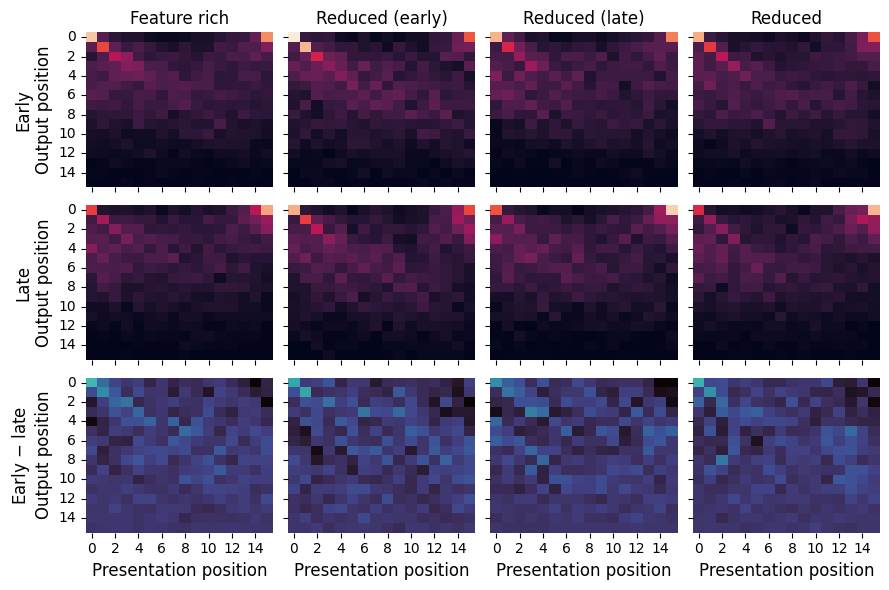

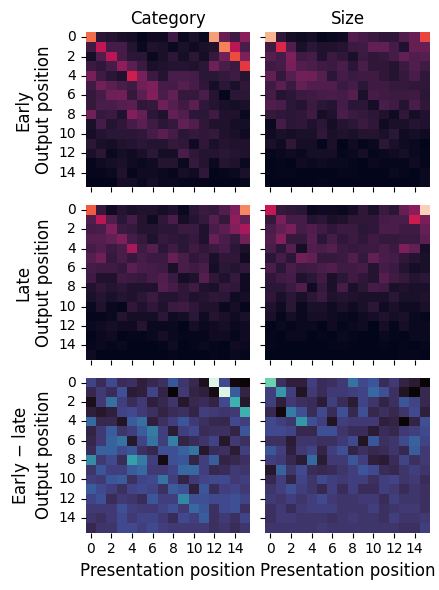

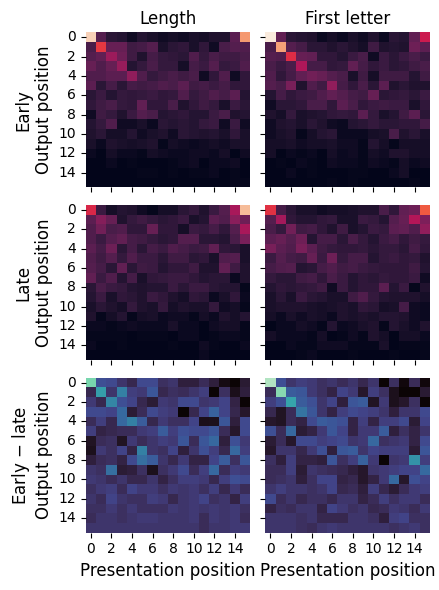

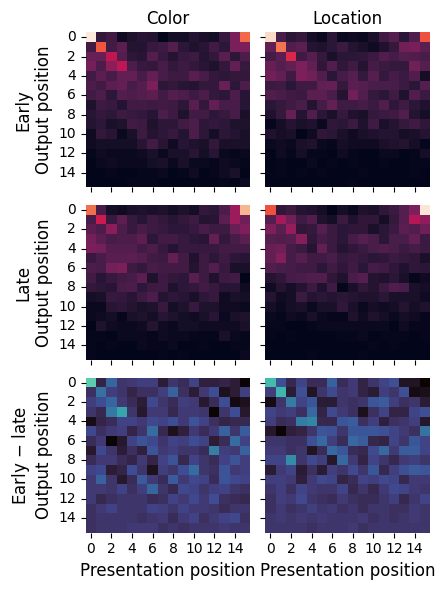

In [18]:
x = pnr_matrix(results['pnr'], include_conds='all')

# non-adaptive heatmaps
for group, conds in feature_groupings.items():
    if group == 'adaptive':
        continue    

    plot_pnr_heatmaps(x, include_conds=conds, contrasts={'Early': 'Late'}, fname=f'pnr_heatmaps_{group}', vmin=0, vmax=0.3, dvmin=-0.05, dvmax=0.15, width=2.25)
    

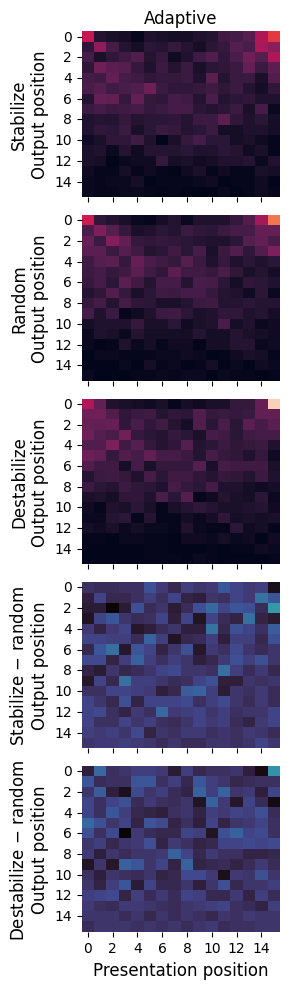

In [19]:
# adaptive heatmaps
plot_pnr_heatmaps(x, include_conds=['adaptive'], include_lists=['stabilize', 'random', 'destabilize'], contrasts={'stabilize': 'random', 'destabilize': 'random'}, fname='pnr_heatmaps_adaptive', vmin=0, vmax=0.3, dvmin=-0.05, dvmax=0.15, width=3, height=2);

# Figure 4: list order effects (by condition)

For each condition (color), plot recall accuracy (y-axis) as a function of list number (x-axis).
  - Panel 1: random conditions (feature rich, reduced (early), reduced(late), and reduced)
  - Panel 2: feature manipulation conditions
  - Panel 3: adaptive conditions (split by list)

In [20]:
def accuracy2df(accuracy):
    columns = accuracy.keys()
    df = pd.concat([v.data for v in accuracy.values()], axis=1)
    df.columns = columns
    return df.reset_index().melt(id_vars=['Subject', 'List'], var_name='Condition', value_name='Accuracy')

def adaptive_listnum2cond(x):
    return listgroups['adaptive'][int(x['Subject'])][int(x['List'])]

In [21]:
# non-adaptive conditions: organize by results key
random_accuracy = accuracy2df({c: results['accuracy by list'][c] for c in feature_groupings['random']})
nonadaptive_accuracy = accuracy2df({c: results['accuracy by list'][c] for c in non_adaptive if c not in feature_groupings['random']})

# adaptive conditons: assign manually
adaptive_accuracy = results['accuracy by list']['adaptive'].data.reset_index().rename({0: 'Accuracy'}, axis=1)
adaptive_accuracy['Condition'] = adaptive_accuracy.apply(adaptive_listnum2cond, axis=1)

In [22]:
def accuracy_by_list(x, xlim=[0, 15], ylim=[0, 1], fname=None):
    _, inds = np.unique(x['Condition'], return_index=True)
    conds = [x['Condition'][i] for i in sorted(inds)]
    
    palette = [colors[c] for c in conds]
    fig = plt.figure(figsize=(5.5, 2.5))
    sns.lineplot(data=x, x='List', y='Accuracy', hue='Condition', palette=palette, legend=False)
    plt.xlabel('List number', fontsize=12)
    plt.ylabel('Recall probability', fontsize=12)
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    return fig

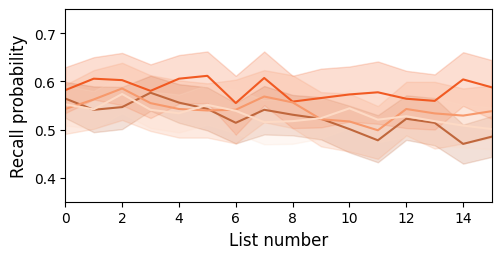

In [23]:
accuracy_by_list(random_accuracy, ylim=[0.35, 0.75], fname='random_accuracy_by_listnum');

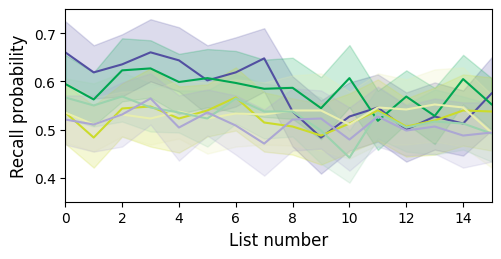

In [24]:
accuracy_by_list(nonadaptive_accuracy, ylim=[0.35, 0.75], fname='nonadaptive_accuracy_by_listnum');

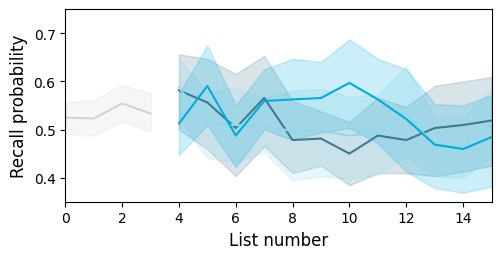

In [25]:
accuracy_by_list(adaptive_accuracy, ylim=[0.35, 0.75], fname='nonadaptive_accuracy_by_listnum');

for each type of (main) analysis:

Figure 1:
  - Panel 1: early lists for non-adaptive conditions
  - Panel 2: late lists for non-adaptive conditions
  - Panel 3: adaptive conditions

Figure 2:
  - Panel 1: early vs. late diffs (late - early)
  - Panel 2: stabilize - random, destabilize - random

pfr, lagcrp, spc: line plots

fingerprint, accuracy: bar plots --- *note*: have not made these yet...

---

Figure 3 (aggregate across all conditions/experiments):
  Pnr analyses (for non-adaptive conditions); row: condition, column: position

---

Figure 4: list order effects by condition
  - bar plot of recall accuracy (group: list number; color: condition)

---

Figure 5: Fingerprint "carryover" by feature type (non-adaptive, non-random feature rich only)
  - Scatterplot (color = condition) showing late - early clustering difference (for the given feature type) vs. late - early accuracy
    - idea: does more carryover from early lists increase (or decrease) accuracy on late lists, for any type(s) of features?

---

Figure 6: effects of features:
  - Panel 1: feature rich - reduced for early lists
  - Panel 2: feature rich - reduced for late lists
  - Panel 3: reduced (late) - reduced for late lists
  - Panel 4: feature rich - reduced (early) for late lists

---

Figure 7 (adaptive only)
  Panel 1: Distance from average fingerprint up to that point, by listgroup (x = list number within group; y = distance)
  Panel 2: variance in fingerprints over time, by listgroup
  Panel 3: scatterplot (each listgroup = different color, list number within group = size) where x = distance between current fingerprint vs. average prior to that point and y = accuracy
  

Figure 8: (adaptive only)
  - Panel 1: random; Panel 2: stabilize; Panel 3: destabilize
  - Scatter plots showing (for each feature) average fingerprint (for that feature dimension) on x axis and accuracy (overall) on y axis